Matplotlib is building the font cache; this may take a moment.


🔬 Validating Strategy: kBONK vs ONDO
Loading data for 2 coins (Lookback: 60 days)...
Aligning and cleaning dataframes...
Success! Loaded matrix with shape: (1441, 6)
✅ Loaded 1441 hours of data.


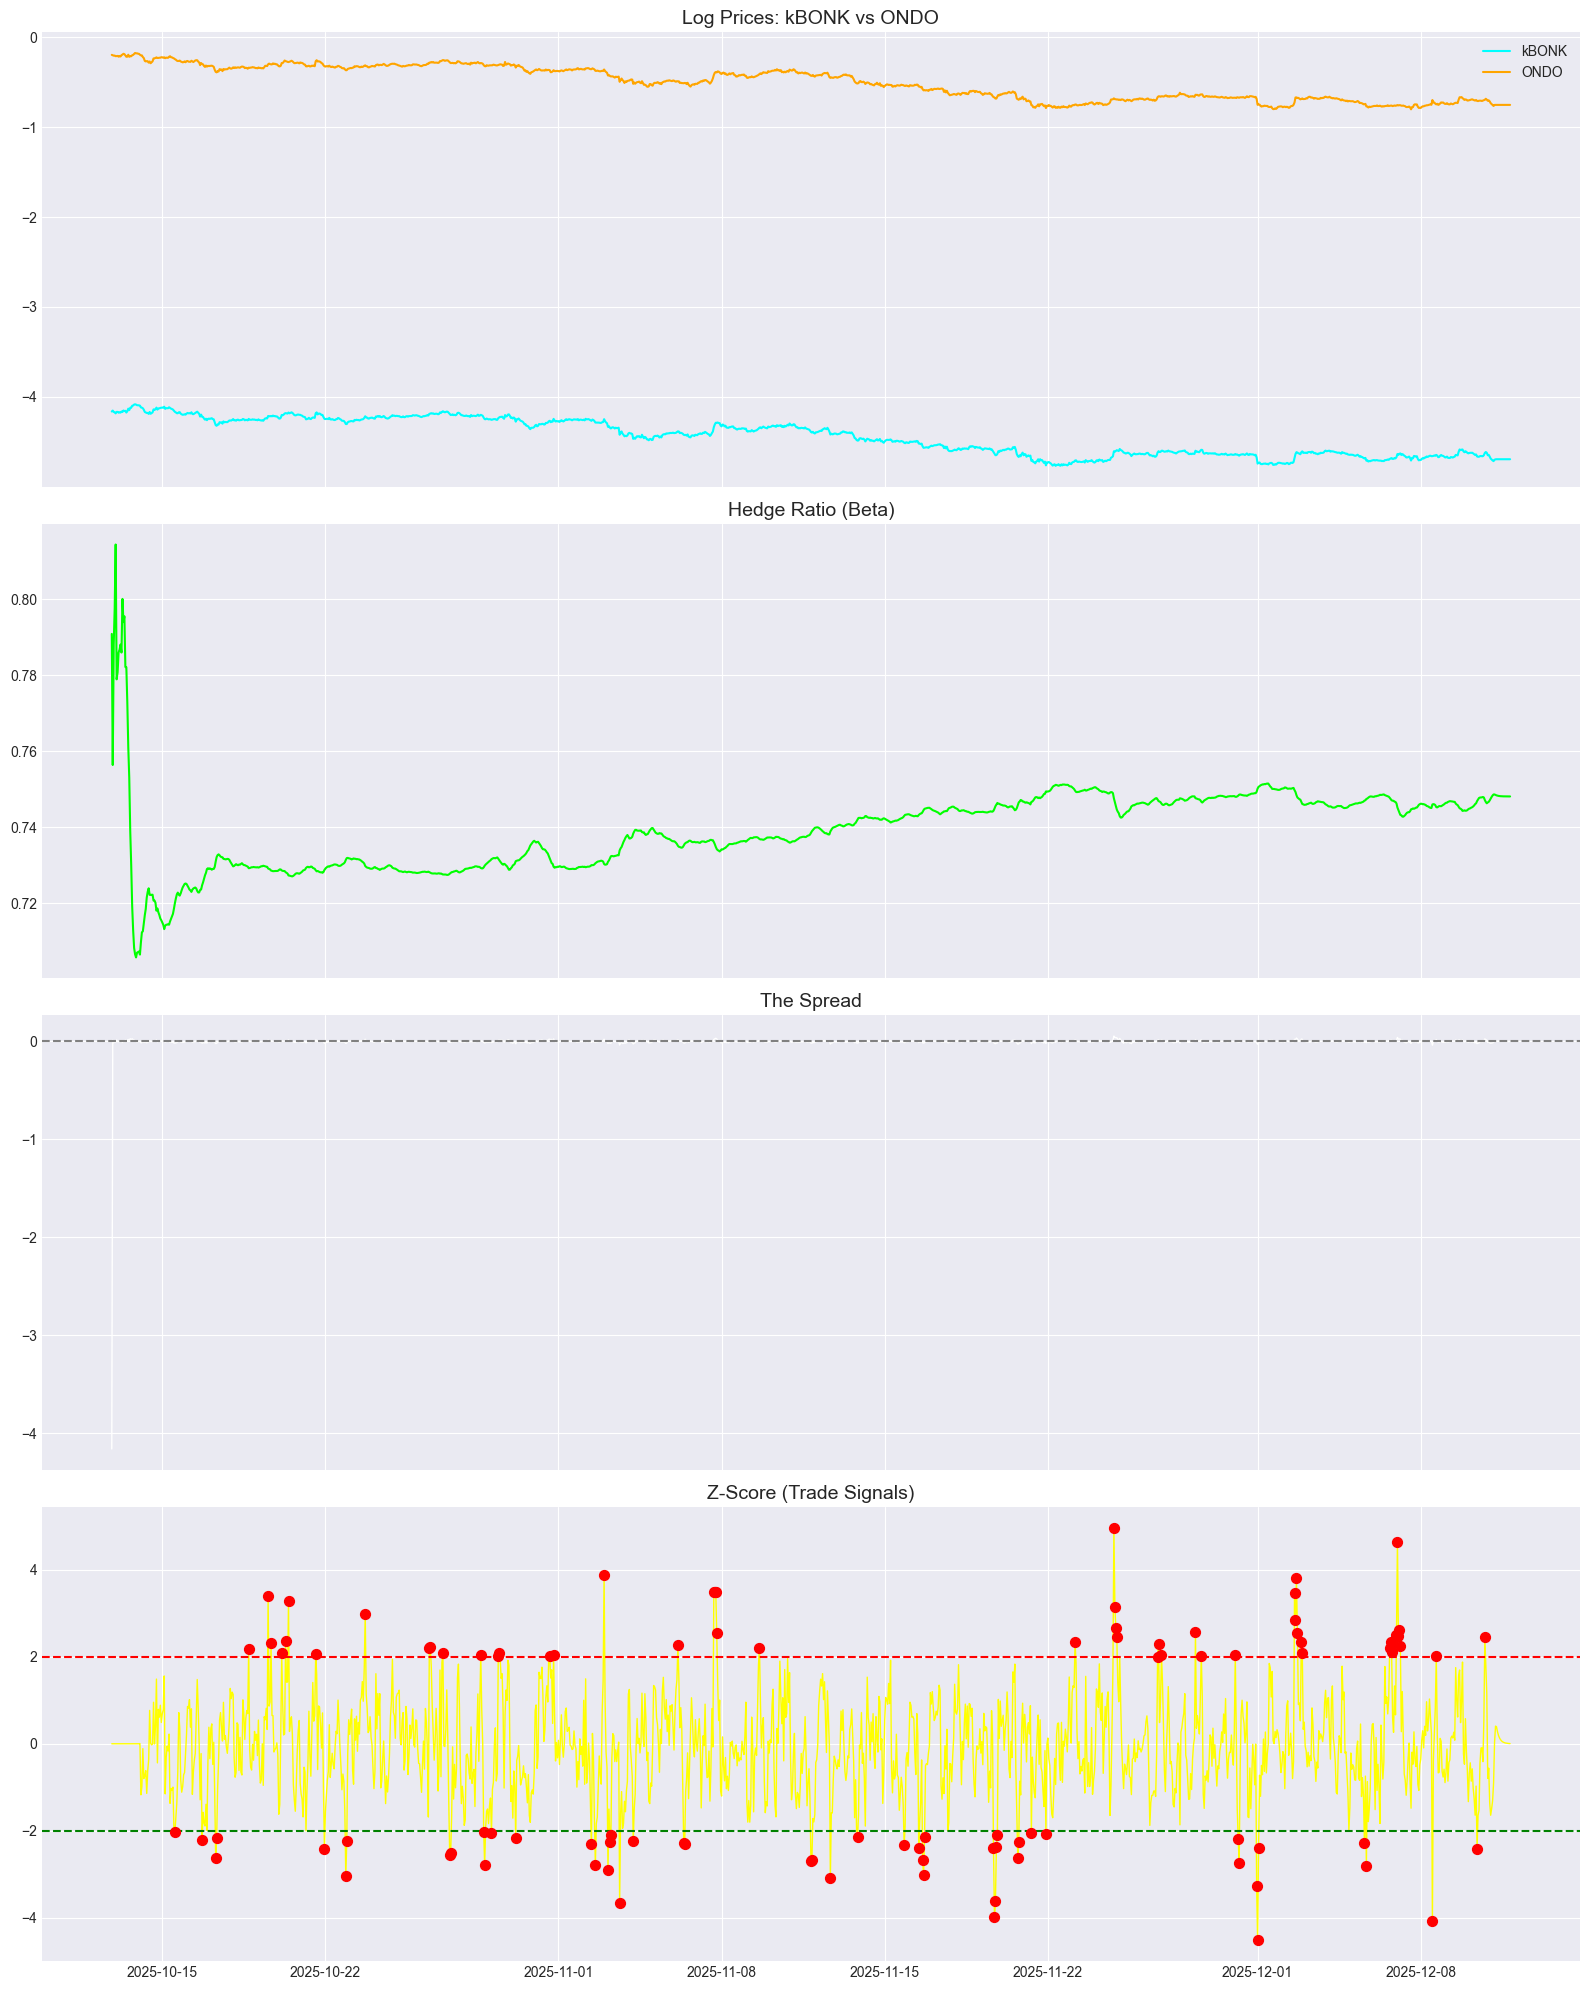

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. SETUP PATHS ---
# Add the project root to python path so we can import src
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# --- 2. HYBRID CONNECTION CONFIG ---
# If running locally, point to localhost. If in Docker, use 'questdb'.
os.environ['QUESTDB_HOST'] = 'localhost' 
# ^^^ This line creates the magic bridge to your Docker database

from src.utils.loader import DataLoader
from src.models.kalman import KalmanFilterRegime

# --- 3. CONFIGURATION ---
PAIR_Y = 'kBONK' 
PAIR_X = 'ONDO'
LOOKBACK_DAYS = 60

print(f"🔬 Validating Strategy: {PAIR_Y} vs {PAIR_X}")

# --- 4. LOAD DATA ---
loader = DataLoader([PAIR_Y, PAIR_X])
df = loader.fetch_data(LOOKBACK_DAYS)

if df.empty:
    print("❌ Error: No data found. Is your Docker QuestDB running?")
else:
    # Extract Log Prices
    closes = df.xs('close', axis=1, level=1).ffill()
    log_prices = np.log(closes)

    # Align Data
    data = log_prices[[PAIR_Y, PAIR_X]].dropna()
    prices_y = data[PAIR_Y].values
    prices_x = data[PAIR_X].values

    print(f"✅ Loaded {len(data)} hours of data.")

    # --- 5. RUN KALMAN FILTER ---
    kf = KalmanFilterRegime(delta=1e-5, R=1e-4, rolling_window=30)
    results = []
    signals = []

    for i, (y, x) in enumerate(zip(prices_y, prices_x)):
        res = kf.update(y, x)
        record = {
            'time': data.index[i],
            'price_y': y,
            'price_x': x,
            'beta': res['hedge_ratio'],
            'spread': res['spread_error'],
            'z_score': res['z_score'],
            'is_signal': res['is_signal']
        }
        results.append(record)
        if res['is_signal']:
            signals.append(record)

    df_res = pd.DataFrame(results).set_index('time')

    # --- 6. PLOT ---
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, axes = plt.subplots(4, 1, figsize=(16, 20), sharex=True)

    # Prices
    axes[0].set_title(f"Log Prices: {PAIR_Y} vs {PAIR_X}", fontsize=14)
    axes[0].plot(df_res.index, df_res['price_y'], label=PAIR_Y, color='cyan')
    axes[0].plot(df_res.index, df_res['price_x'], label=PAIR_X, color='orange')
    axes[0].legend()

    # Beta
    axes[1].set_title("Hedge Ratio (Beta)", fontsize=14)
    axes[1].plot(df_res.index, df_res['beta'], color='lime')

    # Spread
    axes[2].set_title("The Spread", fontsize=14)
    axes[2].plot(df_res.index, df_res['spread'], color='white', linewidth=1)
    axes[2].axhline(0, color='grey', linestyle='--')

    # Z-Score
    axes[3].set_title("Z-Score (Trade Signals)", fontsize=14)
    axes[3].plot(df_res.index, df_res['z_score'], color='yellow', linewidth=1)
    axes[3].axhline(2.0, color='red', linestyle='--')
    axes[3].axhline(-2.0, color='green', linestyle='--')

    if signals:
        sig_times = [x['time'] for x in signals]
        sig_z = [x['z_score'] for x in signals]
        axes[3].scatter(sig_times, sig_z, color='red', s=50, zorder=5)

    plt.tight_layout()
    plt.show()
    

🔬 STARTING AI BRAIN SCAN...
--- 1. Loading & Engineering Data ---
Connecting to Hyperliquid L1 Blockchain...
--- Loading Data for 70 days ---
Loading data for 50 coins (Lookback: 70 days)...
Aligning and cleaning dataframes...
DEBUG: BTC Start Price: 120637.0
Success! Loaded matrix with shape: (1681, 150)
✅ Loaded matrix: (1681, 150)
--- Calculating 7 Critical Strategic Features ---
✅ Generated 7 features for 50 coins.
--- 2. Training Autoencoder ---
🧠 Training Denoising Autoencoder (Arch: 7->16->8->4)...
   Epoch 0: Loss = 1.741033
   Epoch 500: Loss = 0.059542
   Epoch 1000: Loss = 0.036256
   Epoch 1500: Loss = 0.027360
   Epoch 2000: Loss = 0.024492
📊 Generating MRI Scan of the Market...
✅ Success! MRI saved to: research/brain_scan.png


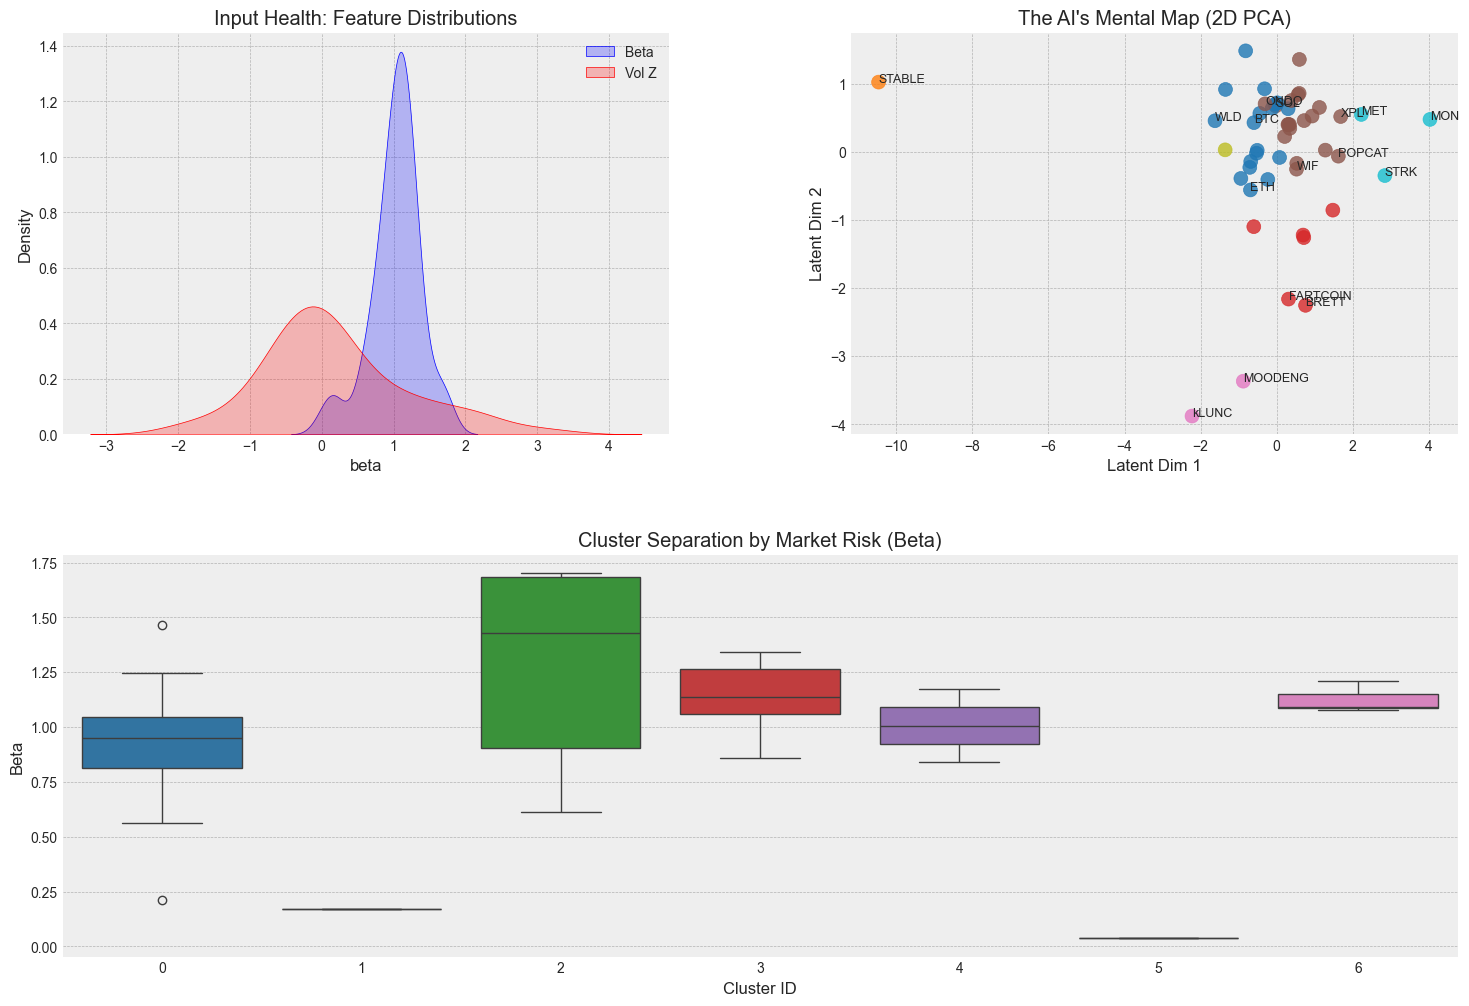

In [4]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

# --- 1. SETUP HYBRID PATHS ---
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Point to Localhost for QuestDB
os.environ['QUESTDB_HOST'] = 'localhost'

from src.utils.universe import get_liquid_universe
from src.features.engineering import FeatureEngineer
from src.models.autoencoder import train_autoencoder

print("🔬 STARTING AI BRAIN SCAN...")

# --- 2. RE-RUN PIPELINE ---
print("--- 1. Loading & Engineering Data ---")
universe = get_liquid_universe(50)
engine = FeatureEngineer(universe)
engine.load_data(lookback_days=60)
raw_features = engine.calculate_features()

if raw_features.empty:
    print("❌ Error: No features calculated. Is QuestDB running?")
    sys.exit(1)

print("--- 2. Training Autoencoder ---")
model, latent_space = train_autoencoder(raw_features)

# Scale Latent Space
latent_scaler = RobustScaler()
latent_scaled = latent_scaler.fit_transform(latent_space)

# Cluster
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(latent_scaled)
raw_features['cluster'] = clusters

# --- 3. VISUALIZATION ---
print("📊 Generating MRI Scan of the Market...")
plt.style.use('bmh')
fig = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(2, 2, hspace=0.3, wspace=0.3)

# PLOT A: Feature Health
ax1 = fig.add_subplot(grid[0, 0])
sns.kdeplot(data=raw_features, x='beta', fill=True, ax=ax1, color='blue', label='Beta')
sns.kdeplot(data=raw_features, x='volatility_z', fill=True, ax=ax1, color='red', label='Vol Z')
ax1.set_title("Input Health: Feature Distributions")
ax1.legend()

# PLOT B: Latent Space Projection (2D PCA)
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_scaled)

ax2 = fig.add_subplot(grid[0, 1])
scatter = ax2.scatter(latent_2d[:, 0], latent_2d[:, 1], c=clusters, cmap='tab10', s=100, alpha=0.8)
ax2.set_title("The AI's Mental Map (2D PCA)")
ax2.set_xlabel("Latent Dim 1")
ax2.set_ylabel("Latent Dim 2")
for i, txt in enumerate(raw_features.index):
    if abs(latent_2d[i, 0]) > 1.5 or abs(latent_2d[i, 1]) > 1.5 or txt in ['BTC', 'ETH', 'SOL', 'WIF', 'ONDO']:
        ax2.annotate(txt, (latent_2d[i, 0], latent_2d[i, 1]), fontsize=9)

# PLOT C: Cluster Risk Profile
ax3 = fig.add_subplot(grid[1, :])
# FIX: Updated syntax to remove FutureWarning
sns.boxplot(x='cluster', y='beta', hue='cluster', data=raw_features, ax=ax3, palette='tab10', legend=False)
ax3.set_title("Cluster Separation by Market Risk (Beta)")
ax3.set_xlabel("Cluster ID")
ax3.set_ylabel("Beta")

# --- FIX: Ensure directory exists before saving ---
output_dir = "research"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = os.path.join(output_dir, "brain_scan.png")
plt.savefig(output_path)
print(f"✅ Success! MRI saved to: {output_path}")